In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Brute-forcing Jaccard similarity computations
This computes actual Jaccard similarities for records in the cora data, rather than an approximation. These Jaccard similarity scores allow us to compare scores as approximated by minhashing, which we will implement for similarity joins in Myria.

The Jaccard index $\mathcal{J}$ on two sets $A$ and $B$ is defined as $$\mathcal{J}(A,B) = \frac{|A \cap B|}{|A \cup B|}$$

$A$ and $B$ each represent a *set* (not tuple?) of ngrams for the title of a record.

## Misc. considerations:
### Handling similarity of varying parts of the record
For now, just handling the Jaccard similarity of titles. 

### Do we want the Jaccard coefficient (as above) or the distance (1 - above)?
I think we want the coefficient but I haven't thought about it enough yet to be fully convinced.

###  Whatever I'm doing with the data is probably wrong
I have never had an explicit need to use pandas but this is a good time to learn... 100% open to corrections & suggestions because I will mess up and/or inadvertently use sub-optimal features in the learning process!

In [2]:
# from http://locallyoptimal.com/blog/2013/01/20/elegant-n-gram-generation-in-python/
def find_ngrams(input_list, n):
  return zip(*[input_list[i:] for i in range(n)])

cora_data = pd.DataFrame.from_csv("../data/cora/cora.txt", sep='\t', header=None)
cora_data['ngram_titles'] = cora_data[4].apply(find_ngrams, n=5)

## Jaccard similarity function

**Input:** A list or set of chars

**Output:** A float in the range (0,1) representing the Jaccard similarity of the two sets

In [3]:
def jaccard_similarity(A, B):
    A = set(A)
    B = set(B)
    n = len(A.intersection(B))
    return n / float(len(A) + len(B) - n) 

Testing functionality:

In [4]:
titles = cora_data['ngram_titles']
titles = np.array(titles)

print jaccard_similarity(titles[0], titles[1])

A = [0,1,2,5,6]
B = [0,2,3,5,7,9]

print "computed:", jaccard_similarity(A, B), "should be: 0.375", 

0.0336134453782
computed: 0.375 should be: 0.375


### Computing J(A,B) for all pairs
How do we want to represent the output? I propose using the sorted indices of the records in a dict 

    jaccard_title = {(i,j):J(title(i), title(j), ...}
    
**Input:** records: np array where each row contains ngrams representing a record

**Output:** dict with `key=(i,j)` where ints `i<j` are record indices and value=`J(record[i], record[j])`

In [5]:
def jaccard_for_pairs(records):
    sims = {}
    n_records = len(records)
    for i in range(n_records):
        for j in range(n_records):
            if i<j:
                sims[(i,j)] = jaccard_similarity(records[i], records[j])
    return sims

jaccard_title = jaccard_for_pairs(titles)
print jaccard_title.get((0,1)) # Cool, same as above

0.0336134453782


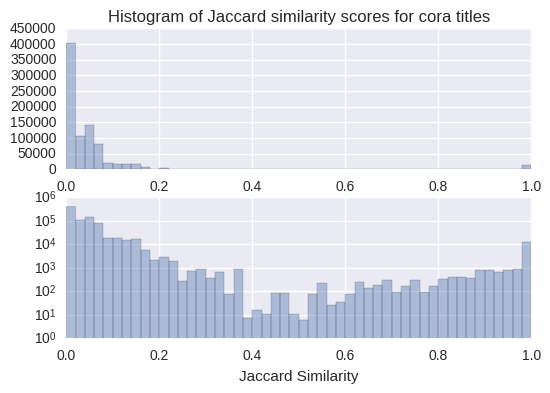

In [6]:
fig, ax = plt.subplots(2)

sns.distplot(jaccard_title.values(), ax=ax[0], kde=False)
ax[0].set_xlabel("Jaccard Similarity")
ax[0].set_title("Histogram of Jaccard similarity scores for cora titles")

sns.distplot(jaccard_title.values(), ax=ax[1], kde=False)
ax[1].set_xlabel("Jaccard Similarity")
ax[1].set_yscale('log')

# Jaccard on the whole record

Decisions to make:

* Handling `NaN`s (empty fields)
    * Currently filling the DataFrame with "", which produces an empty list in the ngram function. This should **not** inflate the similarity because it cannot compare on absence (i.e. it adds nothing to the list of potentially similar ngrams and therefore it's just ignored). I think this is correct behavior.
* Fields with `<n` chars (e.g. year when `n>4`)
    * Currently the behavior of find_ngrams pads the end of the string with space chars. What is the effect of doing this?


### Prepping the data by computing ngrams

Surely there's a better way to do this besides writing out all of the fields...

In [7]:
cora_data.fillna("", inplace=True)
cora_data['ngram_author'] = cora_data[2].apply(find_ngrams, n=5)
cora_data['ngram_volume'] = cora_data[3].apply(find_ngrams, n=5)
cora_data['ngram_title'] = cora_data[4].apply(find_ngrams, n=5)
cora_data['ngram_institute'] = cora_data[5].apply(find_ngrams, n=5)
cora_data['ngram_venue'] = cora_data[6].apply(find_ngrams, n=5)
cora_data['ngram_address'] = cora_data[7].apply(find_ngrams, n=5)
cora_data['ngram_pub'] = cora_data[8].apply(find_ngrams, n=5)
cora_data['ngram_year'] = cora_data[9].apply(find_ngrams, n=5)
cora_data['ngram_pages'] = cora_data[10].apply(find_ngrams, n=5)
cora_data['ngram_editor'] = cora_data[11].apply(find_ngrams, n=5)
cora_data['ngram_note'] = cora_data[12].apply(find_ngrams, n=5)
cora_data['ngram_month'] = cora_data[13].apply(find_ngrams, n=5)

Append all of the `ngram_*` columns of `cora_data`:

In [8]:
cora_ngrams = []
for record in cora_data.ix[:,14:].values.tolist():
    cora_ngrams.append([item for sublist in record for item in sublist])

In [9]:
jaccard_cora_all = jaccard_for_pairs(cora_ngrams)

Sanity check to make sure we computed the same # of pairs:

In [10]:
assert len(jaccard_title.keys()) == len(jaccard_cora_all.keys())

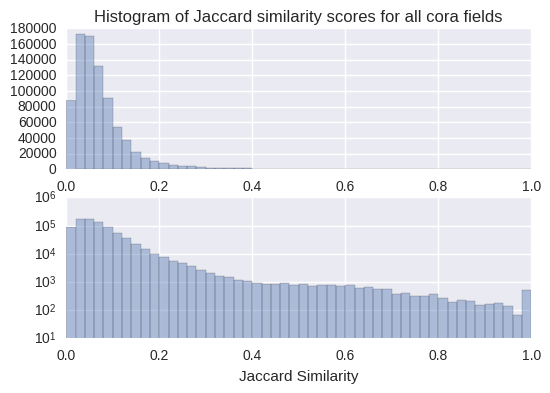

In [11]:
fig, ax = plt.subplots(2)

sns.distplot(jaccard_cora_all.values(), ax=ax[0], kde=False)
ax[0].set_xlabel("Jaccard Similarity")
ax[0].set_title("Histogram of Jaccard similarity scores for all cora fields")

sns.distplot(jaccard_cora_all.values(), ax=ax[1], kde=False)
ax[1].set_xlabel("Jaccard Similarity")
ax[1].set_yscale('log')

In [35]:
# I want to write this out as it would be written out by the MyriaL similarity join code
# Format is something like: "recordid\trecordid\tsim"
# Python doesn't really do this well natively
def write_jaccard(sim_dict, fname):
    with open(fname, "w+") as f:
        for pair,sim in sim_dict.iteritems():
            line = "\t".join([str(x) for x in pair]) + "\t" + str(sim) + "\n"
            f.write(line)
       
write_jaccard(jaccard_title, "../results/cora_titles_jaccardbf.txt")
write_jaccard(jaccard_cora_all, "../results/cora_all_jaccardbf.txt")